# Statistical Analysis for Dark Higgs

- The idea is to convert the below bar chart to an p-value and then make an exclusion contour

![DarkHiggsYeilds](assets/DarkHiggsYields.png)

In [48]:
import ROOT
import json
import numpy as np
import matplotlib.pyplot as plt

print(ROOT.gROOT.GetVersion(),ROOT.xRooFit.GetVersion())

6.37.01 v0.0.1-14-g1b8b81e


In [49]:
signal_yields = json.load(open("dark_higgs_yield.json"))

bkg_yield = {
    "nevents": 0.0304,
    "nevents_err": 0.004387862045841156
}

data_obs = {
    "nevents": 0.0,
    "nevents_err": 0.0
}

print(signal_yields["dh_113900"])

{'mass': 0.23, 'coupling': 0.0007, 'crosssection': 2.246042502785529e-05, 'sumw': 20000, 'nevents': 1.4212844655501689, 'nevents_err': 0.01741451134044757}


In [50]:
def make_histogram(name, yields):
    nevents = yields["nevents"]
    nevents_err = yields["nevents_err"]
    hist = ROOT.TH1D(name, name, 1, 0, 1)
    hist.SetBinContent(1, nevents)
    hist.SetBinError(1, nevents_err)
    hist.SetXTitle("SR")
    hist.SetYTitle("Events")
    return hist

In [51]:
# Make a workspace
limits = {}
for sig_name, sig_yield in signal_yields.items():

    w = ROOT.xRooNode("RooWorkspace", "combined", "my workspace")

    h_bkg = make_histogram("bkg", bkg_yield)
    h_bkg.SetLineColor(ROOT.kRed)
    h_bkg.SetMarkerColor(ROOT.kRed)
    h_bkg.SetFillColor(ROOT.kRed)
    h_bkg.SetMarkerStyle(20)
    h_data = make_histogram("obsData", data_obs)

    w["pdfs/simPdf/SR"].Add(h_bkg)
    w["pdfs/simPdf/SR"].datasets().Add(h_data)

    h_sig = make_histogram(sig_name, sig_yield)
    w["pdfs/simPdf/SR"].Add(h_sig)
    w[f"pdfs/simPdf/SR/{sig_name}"].coefs().Multiply("mu","norm")
    w.poi().Add("mu")

    nll = w["pdfs/simPdf"].nll("obsData")
    hs = nll.hypoSpace("mu")
    hs.scan("cls", 1, 1, 1)
    hs.Print()
    pcls = hs[0].pCLs_asymp()
    pcls_exp = hs[0].pCLs_asymp(nSigma=0)
    pcls_plus1 = hs[0].pCLs_asymp(nSigma=1)
    pcls_plus2 = hs[0].pCLs_asymp(nSigma=2)
    pcls_minus1 = hs[0].pCLs_asymp(nSigma=-1)
    pcls_minus2 = hs[0].pCLs_asymp(nSigma=-2)

    # print("PCLs" ,              pcls)
    # print("PCLs (exp)",         pcls_exp)
    # print("PCLS (+1 sigma)",    pcls_plus1)
    # print("PCLS (+2 sigma)",    pcls_plus2)
    # print("PCLS (-1 sigma)",    pcls_minus1)
    # print("PCLS (-2 sigma)",    pcls_minus2)

    limit = {
        "cls": pcls.value(),
        "cls_exp": pcls_exp.value(),
        "cls_plus1": pcls_plus1.value(),
        "cls_plus2": pcls_plus2.value(),
        "cls_minus1": pcls_minus1.value(),
        "cls_minus2": pcls_minus2.value(),
        
        "cls_err": pcls.error(),
        "cls_exp_err": pcls_exp.error(),
        "cls_plus1_err": pcls_plus1.error(),
        "cls_plus2_err": pcls_plus2.error(),
        "cls_minus1_err": pcls_minus1.error(),
        "cls_minus2_err": pcls_minus2.error(),
    }

    limits[sig_name] = limit
    w.Add(hs.result())
    w.writeToFile(f"workspaces/dark_higgs_{sig_name}.root")

with open("dark_higgs_limits.json", "w") as f:
    json.dump(limits, f, indent=4)

Warning in <TROOT::Append>: Replacing existing TH1: bkg (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: obsData (Potential memory leak).
Info in <xRooNode::Add>: Created pdf RooSimultaneous::simPdf in workspace combined
Info in <xRooNode::Vary>: Created channel RooProdPdf::simPdf_SR in model simPdf
Info in <xRooNode::Multiply>: Created RooRealSumPdf::simPdf_SR_samples in channel simPdf_SR
Info in <xRooNode::Multiply>: Created Shape factor simPdf_SR_samples_bkg_statFactor in prod_simPdf_SR_samples_bkg
Info in <xRooNode::Constrain>: Added poisson constraint pdf RooPoisson::pois_stat_simPdf_SR_samples_bin1 (tau=48.64) for stat_simPdf_SR_samples_bin1
Info in <xRooNode::Add>: Created SimpleDensity factor RooHistFunc::simPdf_SR_samples_bkg for simPdf_SR_samples
[#1] INFO:ObjectHandling -- RooWorkspace::import(combined) importing dataset obsData
Info in <xRooNode::Multiply>: Created Shape factor simPdf_SR_samples_dh_113900_statFactor in prod_simPdf_SR_samples_dh_1

In [104]:
signal_limits = json.load(open("dark_higgs_limits.json"))
signal_yields = json.load(open("dark_higgs_yield.json"))

signal_ids = list(signal_yields.keys())
masses = [signal_yields[sig]["mass"] for sig in signal_ids]
# masses = np.unique(np.array(masses))
# masses = np.sort(masses)
coupl =  [signal_yields[sig]["coupling"] for sig in signal_ids]
# coupl = np.unique(np.array(coupl))
# coupl = np.sort(coupl)

def get_signal_id(mass, coupl):
    for sig in signal_ids:
        if signal_yields[sig]["mass"] == mass and signal_yields[sig]["coupling"] == coupl:
            return sig
    return None

def get_signal_limits(mass, coupl, cls_type="cls"):
    sig_id = get_signal_id(mass, coupl)
    if sig_id is None:
        return None
    return signal_limits[sig_id][cls_type]

cls = [signal_limits[sig]["cls"] for sig in signal_ids]
cls_exp = [signal_limits[sig]["cls_exp"] for sig in signal_ids]
cls_plus1 = [signal_limits[sig]["cls_plus1"] for sig in signal_ids]
cls_plus2 = [signal_limits[sig]["cls_plus2"] for sig in signal_ids]
cls_minus1 = [signal_limits[sig]["cls_minus1"] for sig in signal_ids]
cls_minus2 = [signal_limits[sig]["cls_minus2"] for sig in signal_ids]

In [102]:
x, y = np.meshgrid(masses, coupl)
cls = [get_signal_limits(m, c, "cls") for m, c in zip(np.ravel(x), np.ravel(y))]
cls = np.array(cls).reshape(x.shape)

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

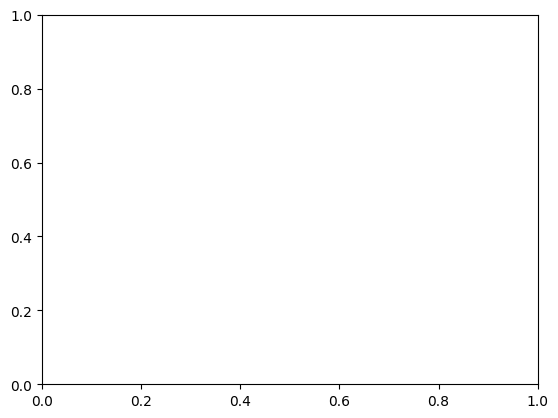

In [103]:
plt.contour(x, y, cls)

In [113]:
from scipy.interpolate import griddata

X = np.linspace(0.1, 1, 100)
Y = np.logspace(-4.5, -2.5, 100)
X, Y = np.meshgrid(X, Y)


int_obs = griddata((masses ,coupl), cls, (X, Y), method='linear')

[]

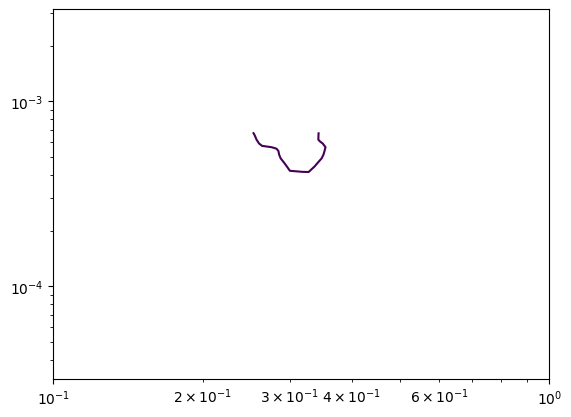

In [114]:
plt.contour(X, Y, int_obs, levels=[0.05])
plt.semilogx()
plt.semilogy()

In [ ]:

Z = interp((X.ravel(), Y.ravel())).reshape(X.shape)

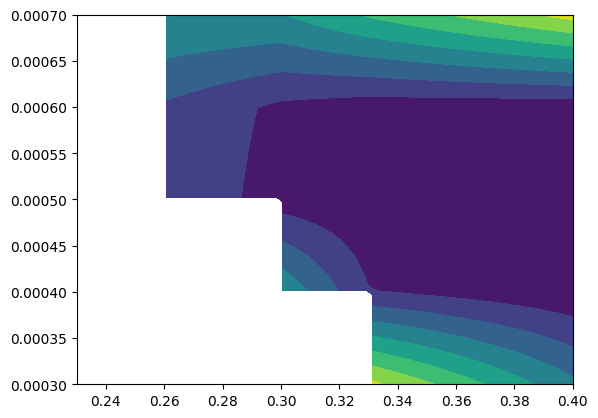

In [93]:
plt.contourf(X, Y, Z)

[]

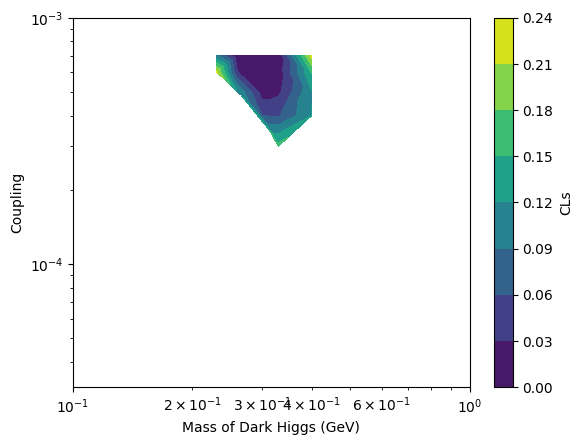

In [ ]:
plt.tricontourf(masses, coupl, cls)

# plt.contour(masses, coupl, cls_exp, colors='black', linestyles='dashed')
plt.colorbar(label='CLs')
plt.xlabel('Mass of Dark Higgs (GeV)')
plt.ylabel('Coupling')
plt.xlim(0.1, 1)
plt.ylim(10**-4.5,10**-3)
plt.semilogx()
plt.semilogy()